In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys
import xarray as xr
import os
sys.path.append(os.path.dirname('../workflow'))
from workflow.scripts.plotting_tools import create_facet_plot, global_map
import snakemake.io as sio
import matplotlib as mpl

In [21]:
p0exp = "../results/piClim-2xdust/"
p0ctrl  = "../results/piClim-control/"
dconc_ctrl = sio.expand(p0ctrl+"derived_variables/concdust/concdust_{model}_piClim-control_Ayear.nc",
                   model = ["NorESM2-LM", "MPI-ESM-1-2-HAM","IPSL-CM6A-LR-INCA","CNRM-ESM2-1","EC-Earth3-AerChem"])

DuREs = sio.expand(p0exp+"ERFs/{erf}/{erf}_piClim-2xdust_{model}_Ayear.nc",
                   model = ["NorESM2-LM", "MPI-ESM-1-2-HAM","IPSL-CM6A-LR-INCA","CNRM-ESM2-1","EC-Earth3-AerChem"], erf=['ERFt'])


dconc_exp = sio.expand(p0exp+"derived_variables/concdust/concdust_{model}_piClim-2xdust_Ayear.nc",
                   model = ["NorESM2-LM", "MPI-ESM-1-2-HAM","IPSL-CM6A-LR-INCA", 
                           "CNRM-ESM2-1", "EC-Earth3-AerChem"])

dod_ctrl = sio.expand(p0ctrl+"od550dust/od550dust_piClim-control_{model}_Ayear.nc",
                   model = ["NorESM2-LM", "MPI-ESM-1-2-HAM","IPSL-CM6A-LR-INCA","CNRM-ESM2-1",
                           "EC-Earth3-AerChem"])


dod_exp = sio.expand(p0exp+"od550dust/od550dust_piClim-2xdust_{model}_Ayear.nc",
                   model = ["NorESM2-LM", "MPI-ESM-1-2-HAM","IPSL-CM6A-LR-INCA", 
                           "CNRM-ESM2-1","EC-Earth3-AerChem"])


In [22]:
erf = {xr.open_dataset(p).attrs['source_id']:
       xr.open_dataset(p)['ERFt'].isel(year=slice(2,None)).mean(dim='year') for p in DuREs}

In [23]:
diff_burden = {
   xr.open_dataset(exp).attrs['intake_esm_attrs:source_id'] : 
    xr.open_dataset(exp)['concdust'].isel(time=slice(2,None)).mean(dim='time')-xr.open_dataset(ctrl)['concdust'].isel(time=slice(2,None)).mean(dim='time') 
            for exp, ctrl in zip(dconc_exp, dconc_ctrl) 
}



/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/

In [24]:
diff_dod = {
       xr.open_dataset(exp).attrs['intake_esm_attrs:source_id'] : 
    xr.open_dataset(exp)['od550dust'].isel(time=slice(2,None)).mean(dim='time')-xr.open_dataset(ctrl)['od550dust'].isel(time=slice(2,None)).mean(dim='time') 
            for exp, ctrl in zip(dod_exp, dod_ctrl) 
}

/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nird/home/ovewh/dustysnake/lib/python3.10/site-packages/

In [7]:
def calc_ERF_per_burden(diff_burden, erfs):
    dsets = []
    for m in diff_burden:
        temp_ds = erfs[m]/diff_burden[m]
        temp_ds = temp_ds.rename(m)
        temp_ds.attrs['name'] = m
        dsets.append(temp_ds)
    return dsets

In [25]:
erfb = calc_ERF_per_burden(diff_burden, erf)
erfod = calc_ERF_per_burden(diff_dod, erf)

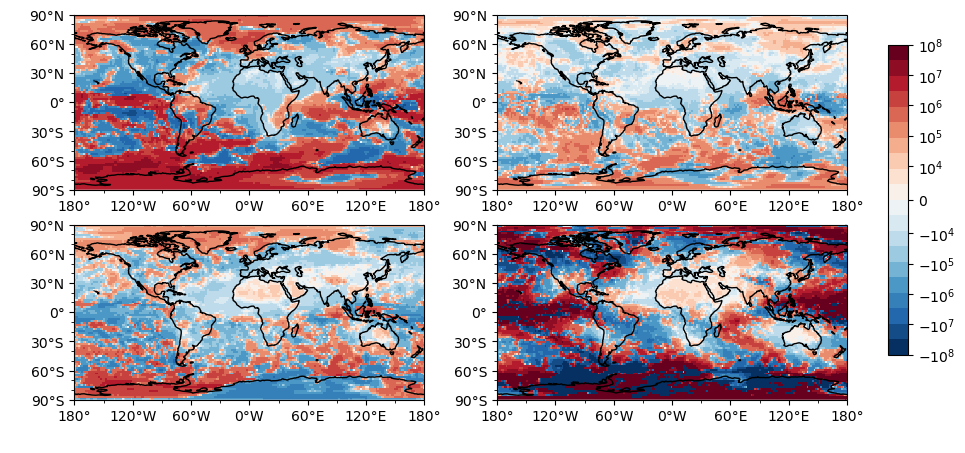

In [27]:
fig ,ax, cax = create_facet_plot(nplots=4,figsize=(10,5))
norm = mpl.colors.SymLogNorm(vmin=-1e8, vmax=1e8, linthresh=1e4
                            )
cmap = mpl.colormaps.get('RdBu_r').resampled(20)                       

for lab, erf in zip(ax, erfb):
    global_map(ax[lab])
    erf.plot(ax=ax[lab], add_colorbar=False, add_labels=False, norm=norm, cmap=cmap)
    
fig.colorbar(mpl.cm.ScalarMappable(norm, cmap), cax=cax)

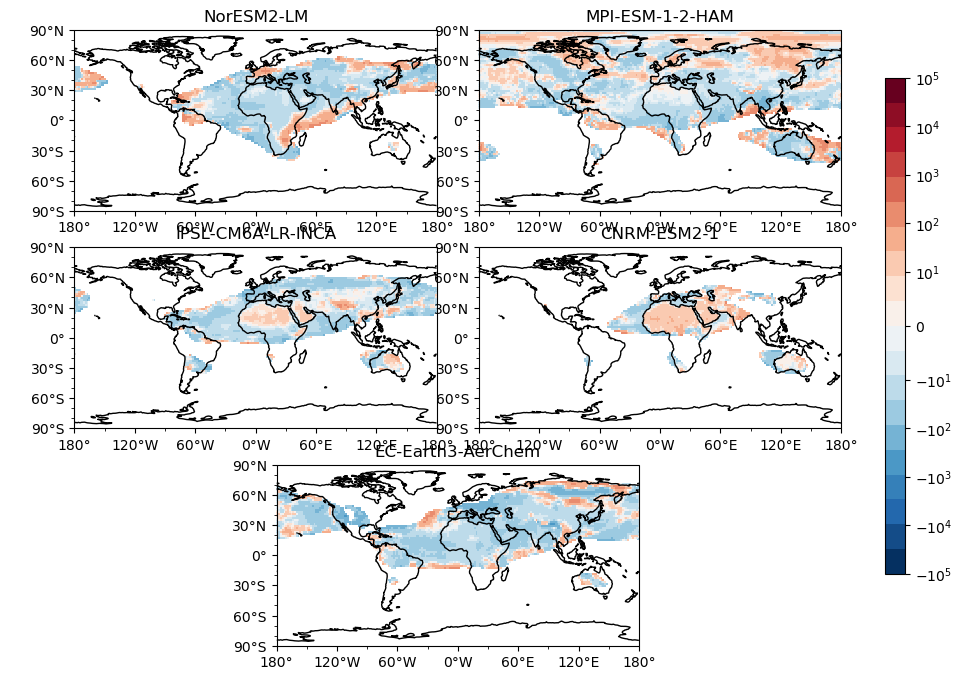

In [29]:
fig ,ax, cax = create_facet_plot(nplots=5,figsize=(10,8))
norm = mpl.colors.SymLogNorm(vmin=-1e5, vmax=1e5, linthresh=1e1)
cmap = mpl.colormaps.get('RdBu_r').resampled(20)               
for lab, erf, m in zip(ax, erfod, diff_dod):
    global_map(ax[lab])
    ax[lab].set_title(erf.name)
    erf = erf.where(diff_dod[m]> 1e-2)
    erf.plot(ax=ax[lab], add_colorbar=False, add_labels=False, norm=norm, cmap=cmap)
    
fig.colorbar(mpl.cm.ScalarMappable(norm, cmap),cax=cax)

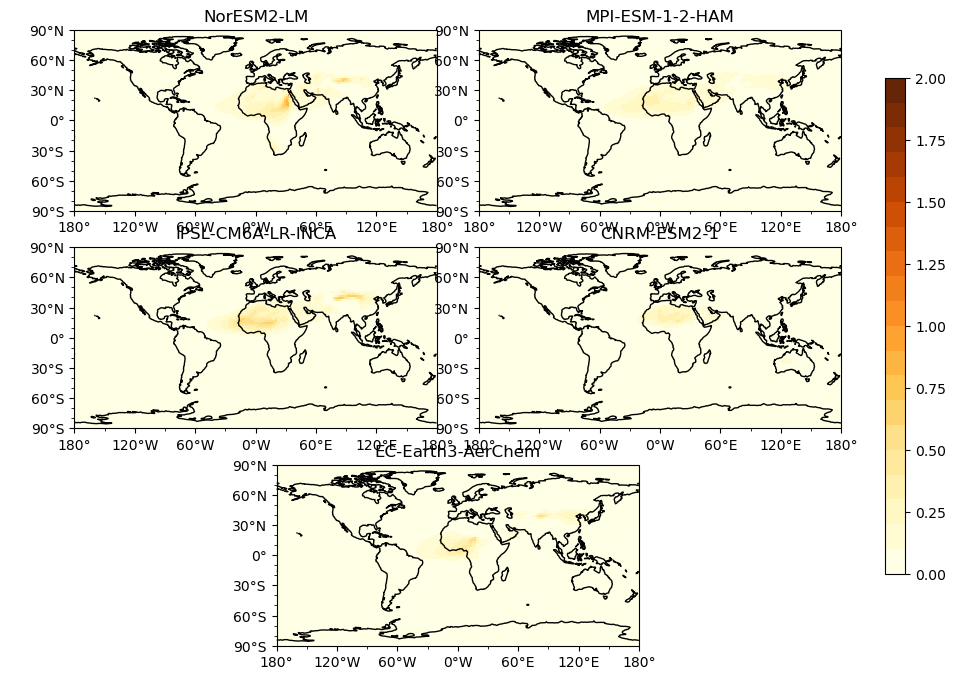

In [30]:
fig ,ax, cax = create_facet_plot(nplots=5,figsize=(10,8))
norm = mpl.colors.Normalize(vmin=0.0,vmax=2)
cmap = mpl.colormaps.get('YlOrBr').resampled(20)               
for lab, m in zip(ax,diff_dod):
    global_map(ax[lab])
    ax[lab].set_title(m)
    diff_dod[m].plot(ax=ax[lab], add_colorbar=False, add_labels=False, norm=norm, cmap=cmap)
    
fig.colorbar(mpl.cm.ScalarMappable(norm, cmap),cax=cax)